In [1]:
import numpy as np

from sklearn.datasets import load_iris, load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from alibi.explainers import PartialDependence, PDEstimatorWrapper, plot_pd
from alibi.datasets import fetch_adult

%load_ext autoreload
%autoreload 2

### Iris dataset

In [2]:
# load dataset
dataset = load_iris()
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [25]:
# train random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

print('Train accuracy: %.2f' % (rf_classifier.score(X_train, y_train)))
print('Test accuracy: %.2f' % (rf_classifier.score(X_test, y_test)))

Train accuracy: 1.00
Test accuracy: 0.97


In [48]:
np.unique(X_train[:, 1])

array([2. , 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3,
       3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.4])

In [70]:
# compute partial dependence
grid_points = {1: np.array([2, 2.5, 3, 3.5, 4, 4.5]), 2: np.array([1, 2])}
print(np.array(list(grid_points.keys())))

pd_classifier = PartialDependence(predictor=rf_classifier)
exp_classifier = pd_classifier.explain(X=X_train,
                                       features_list=[1],
                                       kind='both',
                                       grid_points=grid_points)

[1 2]


In [65]:
np.isin(grid_points.keys(), [1,2,3])

array(False)

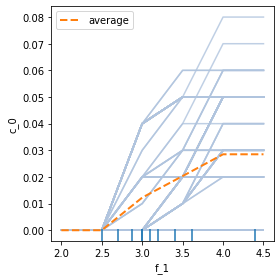

In [54]:
# plot one way pd
plot_pd(exp=exp_classifier,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        centered=True,
        fig_kw = {'figheight': 4, 'figwidth': 4});

In [ ]:
# compute two way pd
exp_classifier = pd_classifier.explain(X=X_train,
                                       features_list=[(0, 1), (1, 2), (2, 3)],
                                       kind='average')

In [ ]:
# plot one way pd
plot_pd(exp=exp_classifier,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw = {'figheight': 8, 'figwidth': 8});

### Boston dataset

In [ ]:
# load dataset
dataset = load_boston()
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# train random forest classifier
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_train, y_train)

print('Train accuracy: %.2f' % (rf_regressor.score(X_train, y_train)))
print('Test accuracy: %.2f' % (rf_regressor.score(X_test, y_test)))

In [ ]:
# compute partial dependence
pd_regressor = PartialDependence(predictor=rf_regressor)
exp_regressor = pd_regressor.explain(X=X_train,
                                     percentiles=(0, 1),
                                     grid_resolution=20,
                                     features_list=[0, 1, 2, 3, (0, 1), (2, 3)], 
                                     kind='average')

In [ ]:
# plot one way pd
plot_pd(exp=exp_regressor,
        features_list='all',
        target_idx=0,
        n_cols=3,
        sharey=None,
        fig_kw = {'figheight': 8, 'figwidth': 12});

In [ ]:
exp_regressor = pd_regressor.explain(X=X_train[:100],
                                     percentiles=(0, 1),
                                     grid_resolution=20,
                                     features_list=[0, 1, 2, 3],
                                     kind='both')

In [ ]:
# plot one way pd
plot_pd(exp=exp_regressor,
        features_list='all',
        target_idx=0,
        n_cols=2,
        centered=True,
        sharey=None,
        fig_kw = {'figheight': 8, 'figwidth': 8});

### Black box - classifier

In [ ]:
# load dataset
dataset = load_iris()
X, y = dataset['data'], dataset['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# train random forest classifier
lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train, y_train)

print('Train accuracy: %.2f' % (lr_classifier.score(X_train, y_train)))
print('Test accuracy: %.2f' % (lr_classifier.score(X_test, y_test)))

In [ ]:
# define black-box predictor
predictor = lr_classifier.predict_proba

In [ ]:
# TODO: consider wrapping the functin inside?
wrapped_predictor = PDEstimatorWrapper(predictor=predictor,
                                       predictor_type='classifier',
                                       prediction_fn='predict_proba',
                                       num_classes=len(np.unique(y_train)))

In [ ]:
# compute partial dependence
pd_blackbox = PartialDependence(predictor=wrapped_predictor)
exp_blackbox = pd_blackbox.explain(X=X_train[:100],
                                   percentiles=(0, 1),
                                   grid_resolution=20,
                                   features_list=[0, 1, 2, 3],
                                   kind='both')

In [ ]:
# plot one way pd
plot_pd(exp=exp_blackbox,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey=None,
        fig_kw = {'figheight': 8, 'figwidth': 8});

### Adult dataset

In [ ]:
# fetch adult datasets
adult = fetch_adult()

# split dataset into train-test-validation
X, y = adult.data, adult.target
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1000, test_size=2000, random_state=13)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=13)

# identify numerical and categorical columns
categorical_ids = list(adult.category_map.keys())
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map]

In [ ]:
# define data preprocessor
num_transf = StandardScaler()
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    drop='first',
)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_ids),
        ('num', num_transf, numerical_ids)
    ],
    sparse_threshold=0
)

# fit data preprocessor
preprocessor = preprocessor.fit(adult.data)

In [ ]:
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [ ]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_ohe, y_train)

In [ ]:
print('Train accuracy: %.2f' % (rf_classifier.score(X_train_ohe, y_train)))
print('Test accuracy: %.2f' % (rf_classifier.score(X_test_ohe, y_test)))

In [ ]:
# TODO: do not support OHE for now
def decorator(func):
    def wrapper(X: np.ndarray, *args, **kwargs):
        X_ohe = preprocessor.transform(X)
        return func(X_ohe, *args, *kwargs)
    return wrapper

In [ ]:
# decorate predict proba
rf_classifier.predict_proba = decorator(rf_classifier.predict_proba)

In [ ]:
explainer = PartialDependence(predictor=rf_classifier,
                              feature_names=adult.feature_names,
                              categorical_names=adult.category_map)

In [ ]:
exp1 = explainer.explain(X=X_train[:100], 
                        features_list=[0, 1, (0, 1), (2, 3)],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='average')

In [ ]:
from copy import deepcopy
exp1minus = deepcopy(exp1)
exp1minus.pd_values = [1 - v for v in exp1.pd_values]

In [ ]:
plot_pd(exp=exp1,
        features_list='all',
        target_idx=0,  # TODO: display for both targets in binary classification
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 8});

In [ ]:
# plot_pd(exp=exp1minus,
#         features_list='all',
#         target_idx=0, 
#         n_cols=2,
#         sharey='row',
#         fig_kw={'figheight': 8, 'figwidth': 8});

In [ ]:
exp2 = explainer.explain(X=X_train[:100], 
                        features_list=numerical_ids,
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='both')

In [ ]:
plot_pd(exp=exp2,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 10});

In [ ]:
exp3 = explainer.explain(X=X_train[:100], 
                        features_list=[3, 5, 7],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='both')

In [ ]:
plot_pd(exp=exp3,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 8});

In [ ]:
ft_list = [adult.feature_names.index('Education'), adult.feature_names.index('Marital Status')]
ft_list

In [ ]:
exp4 = explainer.explain(X=X_train[:100], 
                        features_list=[(2, 3), 2, 3],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        method='auto',
                        kind='average')

In [ ]:
plot_pd(exp=exp4,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 10});

In [ ]:
exp5 = explainer.explain(X=X_train[:5000], 
                        features_list=[(0, 10), 8, 10, 0],
                        response_method='predict_proba',
                        percentiles=(0, 1),
                        grid_resolution=50,
                        method='auto',
                        kind='average')

In [ ]:
plot_pd(exp=exp5,
        features_list='all',
        target_idx=0,
        n_cols=2,
        sharey='row',
        fig_kw={'figheight': 8, 'figwidth': 10});